# 1. Import Libraries/Dataset

## a. Import the required libraries and the dataset

In [1]:
import tensorflow as tf\
    , glob, os, numpy as np, PIL, matplotlib.pyplot as plt

## b. Check the GPU available

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [3]:
tf.zeros((1, 1)).gpu()

Instructions for updating:
Use tf.identity instead.


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>

# 2. Data Visualization and augmentation

## a. Plot at least two samples from each class of the dataset

- - - - - - - - - - - - - - - - - - - - 
-- Class : n01440764


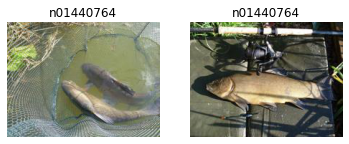

- - - - - - - - - - - - - - - - - - - - 
-- Class : n02102040


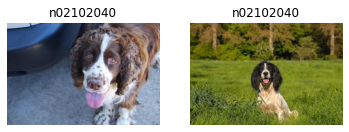

- - - - - - - - - - - - - - - - - - - - 
-- Class : n02979186


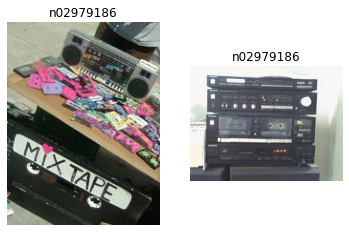

- - - - - - - - - - - - - - - - - - - - 
-- Class : n03000684


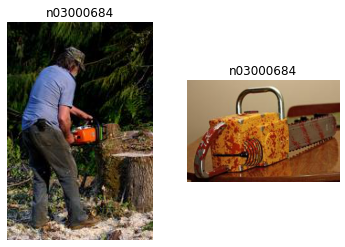

- - - - - - - - - - - - - - - - - - - - 
-- Class : n03028079


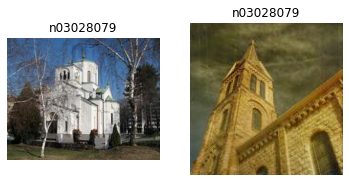

- - - - - - - - - - - - - - - - - - - - 
-- Class : n03394916


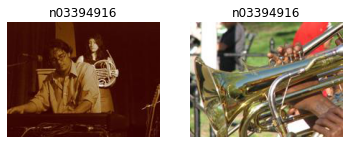

- - - - - - - - - - - - - - - - - - - - 
-- Class : n03417042


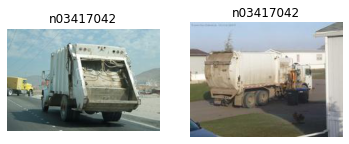

- - - - - - - - - - - - - - - - - - - - 
-- Class : n03425413


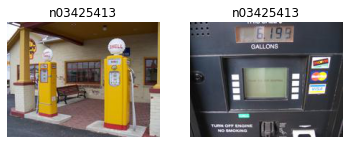

- - - - - - - - - - - - - - - - - - - - 
-- Class : n03445777


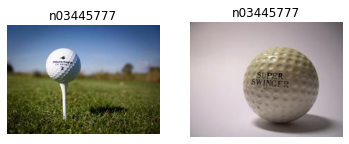

- - - - - - - - - - - - - - - - - - - - 
-- Class : n03888257


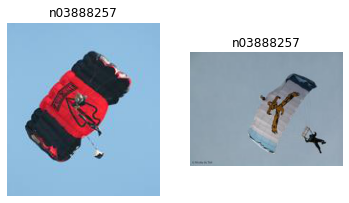

In [4]:
for i, c in enumerate(glob.glob('data/imagenette2-160/train/**')):
    print(*['-']*20, f"\n-- Class : {os.path.basename(c)}")
    _, axs = plt.subplots(1, 2)
    ims = glob.glob(f'{c}/*.JPEG')
    for ii in range(2):
        im = PIL.Image.open(ims[ii])
        axs[ii].imshow(im)
        axs[ii].set_title(os.path.basename(c))
        axs[ii].axis("off")
    plt.show()

## b. Apply rotation and height shift augmentation (horizontal_flip, width_shift_range) to the dataset separately. Print the augmented image and the original image for each class and each augmentation.

-- Class : n01440764


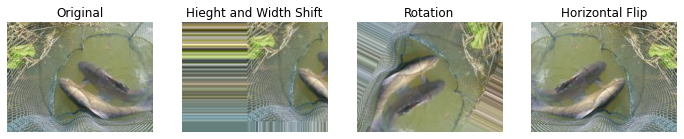

-- Class : n02102040


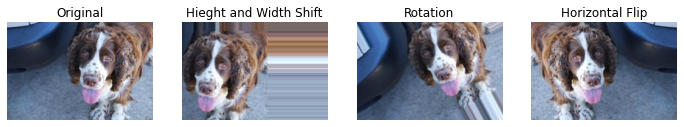

-- Class : n02979186


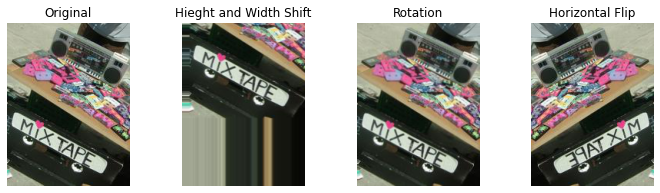

-- Class : n03000684


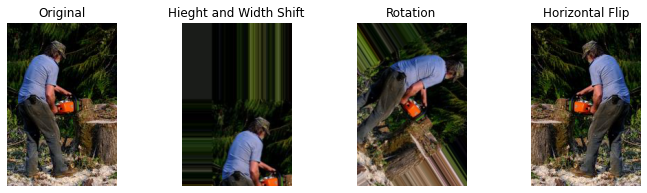

-- Class : n03028079


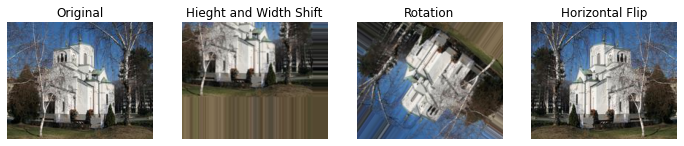

-- Class : n03394916


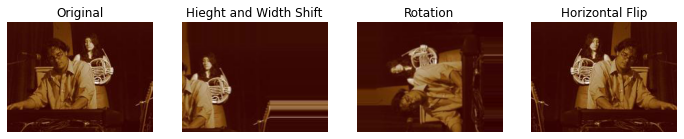

-- Class : n03417042


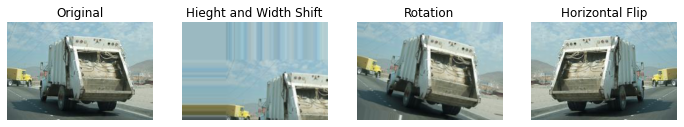

-- Class : n03425413


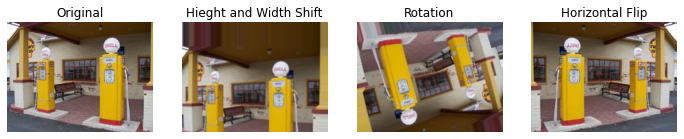

-- Class : n03445777


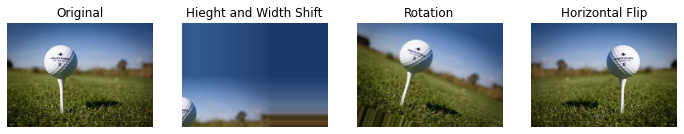

-- Class : n03888257


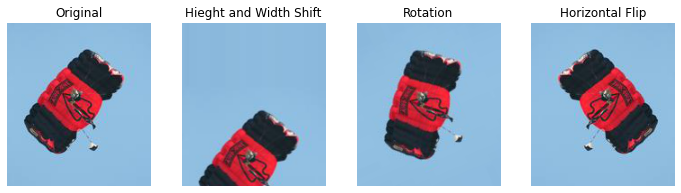

In [19]:
for i, c in enumerate(glob.glob('data/imagenette2-160/train/**')):
    print(f"-- Class : {os.path.basename(c)}")
    im_size = 3
    cols = 4
    _, axs = plt.subplots(1, cols, figsize=(im_size*cols,im_size))
    im = glob.glob(f'{c}/*.JPEG')[0]
    arr = np.array(PIL.Image.open(im), dtype='ubyte')
    #
    axs[0].imshow(arr)
    axs[0].set_title("Original")
    #
    axs[1].imshow(tf.keras.preprocessing.image.random_shift(
        arr, 0.5, 0.5, 0, 1, 2, 
#         'reflect'
    ))
    axs[1].set_title("Hieght and Width Shift")
    #
    axs[2].imshow(tf.keras.preprocessing.image.random_rotation(
        arr, 360, 0, 1, 2, 
#         'reflect'
    ))
    axs[2].set_title("Rotation")
    #
    axs[3].imshow(tf.image.flip_left_right(arr).numpy())
    axs[3].set_title("Horizontal Flip")
    #
    [ax.axis("off") for ax in axs]
    plt.show()
    

## c. Bring the train and test data in the required format.

In [4]:
def norm(arr):
    "Convert and array with range 0,255 to -1,1"
    return (arr - 127)/128

def denorm(arr):
    "Convert and array with range -1,1 to 0,255"
    return (arr*128)+127

train_dl = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=norm,
    # rescale=1./255.
    
).flow_from_directory(
    'data/imagenette2-160/train',
    target_size=(160, 160)
)
valid_dl = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale=1./255.,
    preprocessing_function=norm,
).flow_from_directory(
    'data/imagenette2-160/val',
    target_size=(160, 160)
)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


## d. Print the shapes of train and test data.

In [15]:
x_batch, y_batch = next(train_dl)

In [16]:
x_batch.shape

(32, 256, 256, 3)

X batch shape explaination:
- 32 is the batch_Size 
- 256, 256 is image height and width
- 3 is channels of image

In [17]:
y_batch.shape

(32, 10)

Y batch shape explaination:
- 32 is the batch_Size 
- 10 is the number of classes as this is categorical data and y will be in format one hot encodings

## Plotting some samples from the dataloader

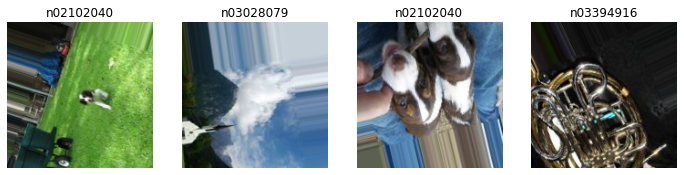

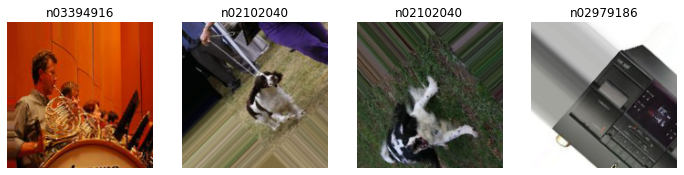

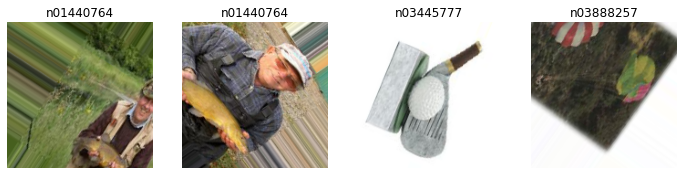

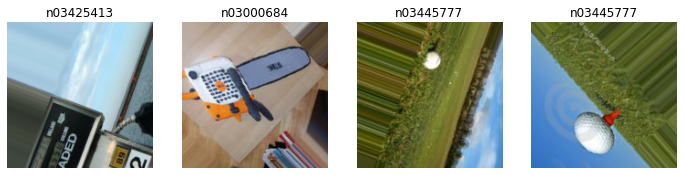

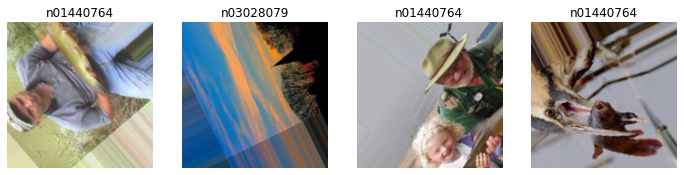

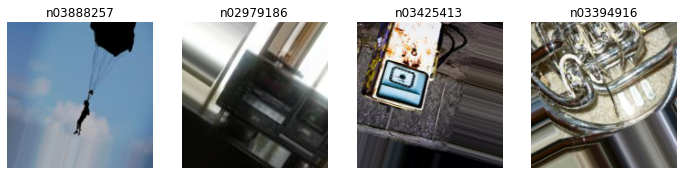

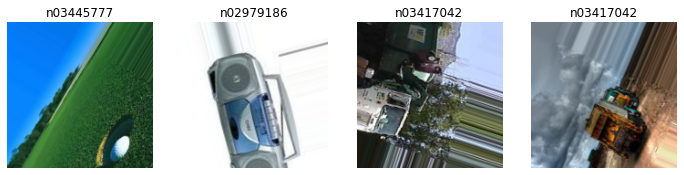

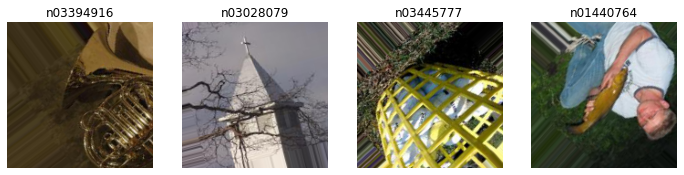

In [6]:
i = 0
cols=4
reverse_class_maping = {j:i for i,j in train_dl.class_indices.items()}
while True:
    if i>=x_batch.shape[0]:
        break
    _, axs = plt.subplots(1, cols, figsize=(3*cols, 3))
    for ii in range(cols):
        if i>=x_batch.shape[0]:
            break
        arr = denorm(x_batch[i]).astype('ubyte')
        axs[ii].imshow(arr)
        axs[ii].set_title(reverse_class_maping[y_batch[i].argmax()])
        axs[ii].axis("off")
        i+=1
    plt.show()

# 3. Model Building

- Sequential Model layers- Use AT LEAST 3 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons.
> We are counting one block of convolution, activation function and batch norm layer as a hidden layer. We would like to use a small model with 4 Hidden Layers. After the hidden layers we would like to flatten the output and apply a dense layer on averag pooled activation to reduce the dimensions of output to that of target predictions. We have not applied softmax activation to the top layer because we want to use logits directly in the loss function as they seem to be more stable numerically.    Reference: [a-guide-to-transfer-learning-with-keras-using-resnet50](https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b)

- Add L2 regularization to all the layers.
> Added

- Add one layer of dropout at the appropriate position and give reasons.
> We will add the dropout layer before all dense layers as they are more prone to overfitting then the Convalution layers. No dropout layer has been applied after the final predictions.

- Choose the appropriate activation function for all the layers.
> We would be using Relu for all the hidden layers and finally a softmax layer at the end. The softmax is used at the end (Called top but) to scale the sum of confidene of all classes to 100% or 1.0 in floating point number.

## a. Create a sequential model

In [8]:
from tensorflow.keras import layers

In [9]:
reg = tf.keras.regularizers.l2()
reg = None
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, 2, padding='same', input_shape=x_batch.shape[1:], data_format="channels_last", kernel_regularizer=reg),
  layers.BatchNormalization(),
  layers.Activation("relu"),
  #
  layers.Conv2D(32, 3, 2, padding='same', kernel_regularizer=reg),
  layers.BatchNormalization(),
  layers.Activation("relu"),
  #
  layers.Conv2D(64, 3, 2, padding='same', kernel_regularizer=reg),
  layers.BatchNormalization(),
  layers.Activation("relu"),
  #
  layers.Conv2D(128, 3, 2, padding='same', kernel_regularizer=reg),
  layers.BatchNormalization(),
  layers.Activation("relu"),
  #
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128),
  layers.BatchNormalization(),
  layers.Activation("relu"),
  #
  layers.Dropout(0.4),
  layers.Dense(len(train_dl.class_indices), kernel_regularizer=reg)
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 40, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        1

# 4. Model Compilation

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.003),
    loss=tf.keras.losses.BinaryCrossentropy(True),
    metrics=['accuracy']
)

# 5. Model Training

In [13]:
import time
start = time.time()

In [14]:
history = model.fit_generator(
    train_dl,
    epochs=50,
    validation_data=valid_dl
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
296/296 [==============================] - 92s 200ms/step - loss: 0.3867 - accuracy: 0.2065 - val_loss: 0.2773 - val_accuracy: 0.3529
Epoch 2/50
296/296 [==============================] - 59s 198ms/step - loss: 0.2768 - accuracy: 0.3538 - val_loss: 0.2708 - val_accuracy: 0.3758
Epoch 3/50
296/296 [==============================] - 58s 196ms/step - loss: 0.2658 - accuracy: 0.3876 - val_loss: 0.2557 - val_accuracy: 0.4252
Epoch 4/50
296/296 [==============================] - 58s 195ms/step - loss: 0.2576 - accuracy: 0.4087 - val_loss: 0.2394 - val_accuracy: 0.4589
Epoch 5/50
296/296 [==============================] - 58s 195ms/step - loss: 0.2525 - accuracy: 0.4251 - val_loss: 0.2704 - val_accuracy: 0.3893
Epoch 6/50
296/296 [==============================] - 58s 195ms/step - loss: 0.2480 - accuracy: 0.4451 - val_loss: 0.2713 - val_accuracy: 0.4094
Epoch 7/50
296/296 [==============================] - 57s 194ms/step - loss: 0.2406 - accuracy: 0.4656 - val_loss: 0.2253 - val_ac

In [18]:
f"-- Total Time Taken to train model: {(time.time() - start)/60:0.3f} Minutes"

'-- Total Time Taken to train model: 47.500 Minutes'

### Save model

In [16]:
model.save('v1_50e')

INFO:tensorflow:Assets written to: v1_50e/assets


# 6. Model Evaluation

## a. Print the final train and validation loss and accuracy

In [44]:
h = f"""
-- Final Model Metrics: 
> Training Loss: {history.history['loss'][-1]:0.3f}     | Validation Loss: {history.history['val_loss'][-1]:0.3f} 
> Training Accuracy: {history.history['accuracy'][-1]:0.3f} | Validation Accuracy: {history.history['val_accuracy'][-1]:0.3f} 
"""
print(h)


-- Final Model Metrics: 
> Training Loss: 0.166     | Validation Loss: 0.188 
> Training Accuracy: 0.666 | Validation Accuracy: 0.609 



## Print confusion matrix and classification report for the validation dataset

In [48]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(valid_dl)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [55]:

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [60]:
print('Confusion Matrix')
cm = confusion_matrix(valid_dl.classes, y_pred)
print(cm)

Confusion Matrix
[[255   1   4  25  60   4   3  11  18   6]
 [ 16 192  10  49  46   4   4  45  20   9]
 [  1   0 258   6  12   5   3  65   4   3]
 [  6   5  22 138  64  10   3 108  16  14]
 [  1   2  15   1 291  17   3  49   8  22]
 [  6   2  19   3  60 228   1  68   3   4]
 [  0   1  27  22  76   8 145 105   2   3]
 [  2   0  20  11  37   7   5 326   5   6]
 [ 13   5  13   7  39   2   2  35 257  26]
 [  7   0   5   9  13   4   9  29  13 301]]


In [59]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

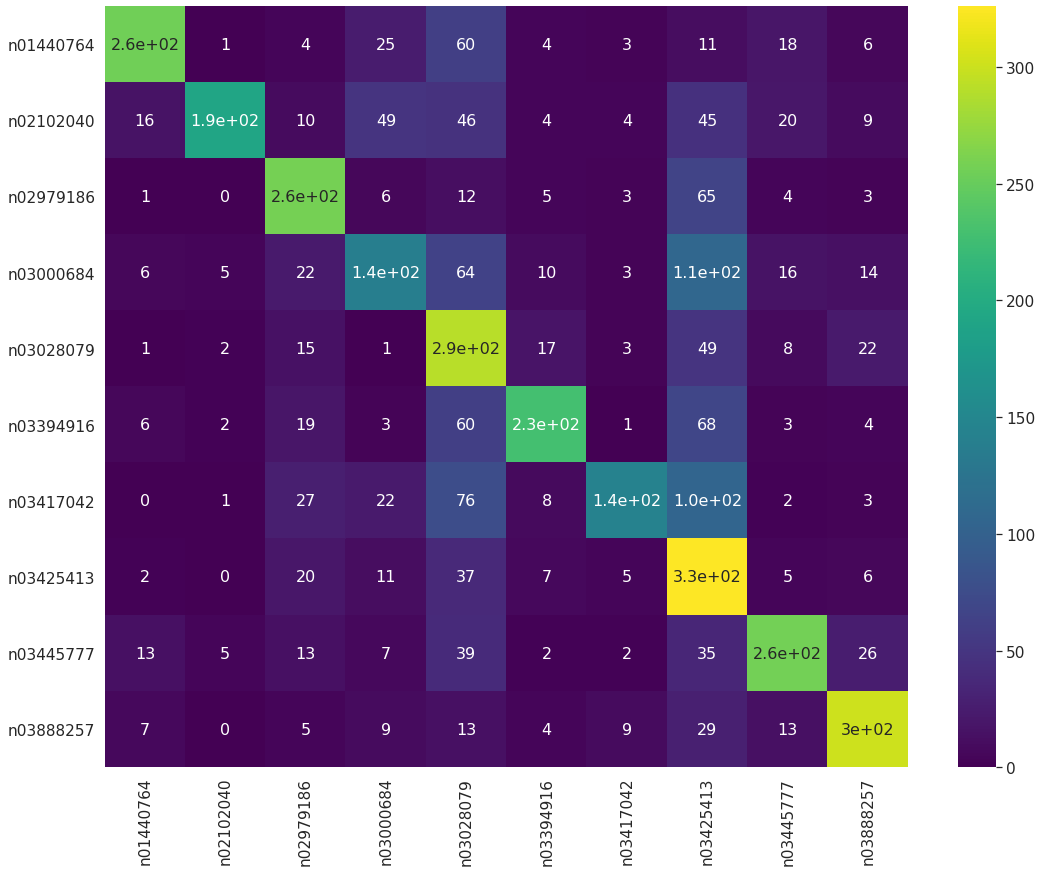

In [94]:
df_cm = pd.DataFrame(cm, valid_dl.class_indices.keys(), valid_dl.class_indices.keys())
plt.figure(figsize=(18,14))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, cmap='viridis', annot=True, annot_kws={"size": 16}) # font size

plt.show()

#### Classification Report

In [97]:
rep = classification_report(valid_dl.classes, y_pred, None, valid_dl.class_indices.keys())
print(rep)

              precision    recall  f1-score   support

   n01440764       0.83      0.66      0.73       387
   n02102040       0.92      0.49      0.64       395
   n02979186       0.66      0.72      0.69       357
   n03000684       0.51      0.36      0.42       386
   n03028079       0.42      0.71      0.53       409
   n03394916       0.79      0.58      0.67       394
   n03417042       0.81      0.37      0.51       389
   n03425413       0.39      0.78      0.52       419
   n03445777       0.74      0.64      0.69       399
   n03888257       0.76      0.77      0.77       390

    accuracy                           0.61      3925
   macro avg       0.68      0.61      0.62      3925
weighted avg       0.68      0.61      0.61      3925



If we look at the above classification report:
- The best performing class is: n03888257 
- The worst performing class is n03000684

## b. Print the two most incorrectly classified images for each class in the test dataset.

In [132]:
conf_ground_truth = np.zeros((valid_dl.n, valid_dl.num_classes), 'float32')
conf_ground_truth[np.arange(valid_dl.n), valid_dl.classes] = 1.
conf_ground_truth

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [140]:
def softmax(x: np.ndarray) -> np.ndarray:
    e_x = np.exp(x - np.max(x, axis=-1)[..., None])
    e_y = e_x.sum(axis=-1)[..., None]
    return e_x / e_y

In [188]:
bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
Y_pred_sft = softmax(Y_pred)
losses = bce(conf_ground_truth,  Y_pred_sft).numpy()
argsrt_losses = losses.argsort()



== Class : n01440764
-- Image: data/imagenette2-160/val/n01440764/n01440764_10462.JPEG


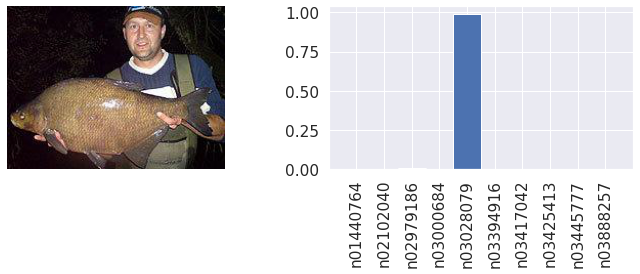

-- Image: data/imagenette2-160/val/n01440764/n01440764_10592.JPEG


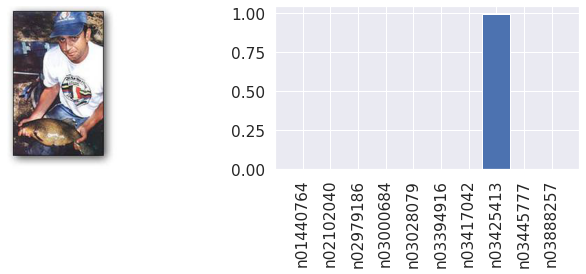



== Class : n02102040
-- Image: data/imagenette2-160/val/n02102040/n02102040_1910.JPEG


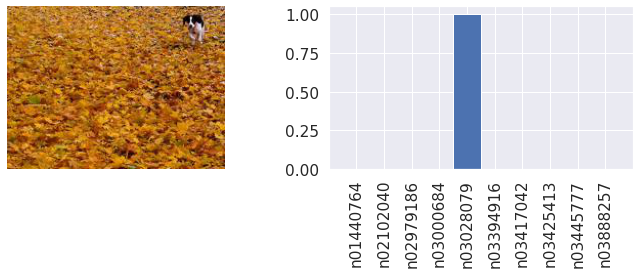

-- Image: data/imagenette2-160/val/n02102040/n02102040_1781.JPEG


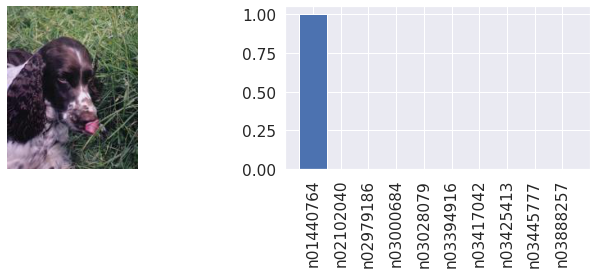



== Class : n02979186
-- Image: data/imagenette2-160/val/n02979186/n02979186_20561.JPEG


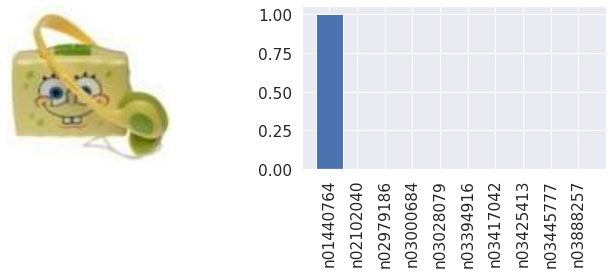

-- Image: data/imagenette2-160/val/n02979186/n02979186_6012.JPEG


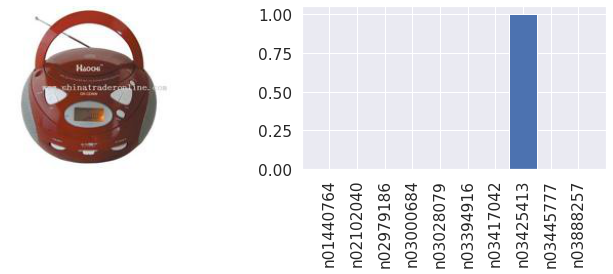



== Class : n03000684
-- Image: data/imagenette2-160/val/n03000684/n03000684_23960.JPEG


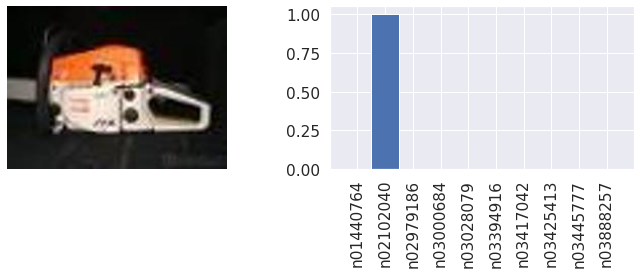

-- Image: data/imagenette2-160/val/n03000684/n03000684_25951.JPEG


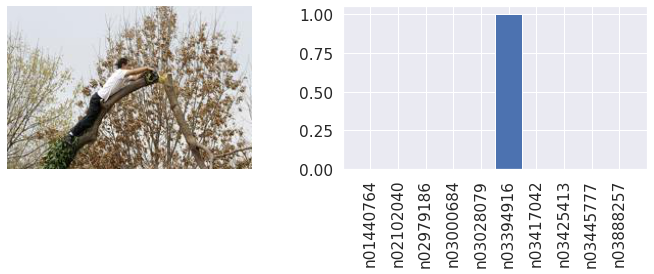



== Class : n03028079
-- Image: data/imagenette2-160/val/n03028079/n03028079_32202.JPEG


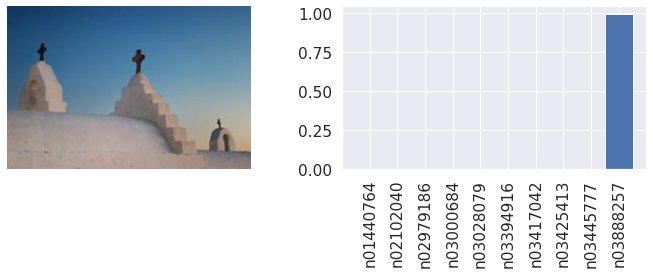

-- Image: data/imagenette2-160/val/n03028079/n03028079_8162.JPEG


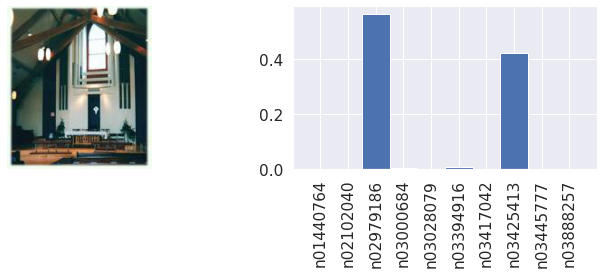



== Class : n03394916
-- Image: data/imagenette2-160/val/n03394916/n03394916_42550.JPEG


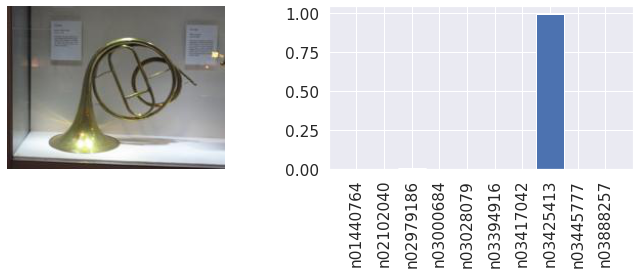

-- Image: data/imagenette2-160/val/n03394916/n03394916_54531.JPEG


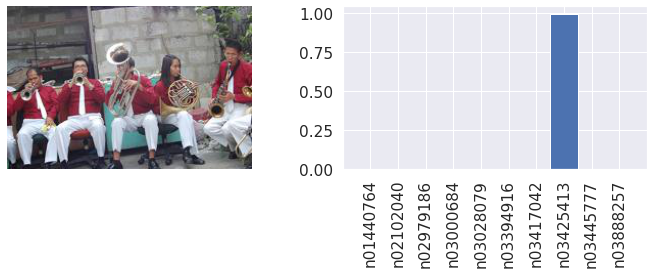



== Class : n03417042
-- Image: data/imagenette2-160/val/n03417042/n03417042_3710.JPEG


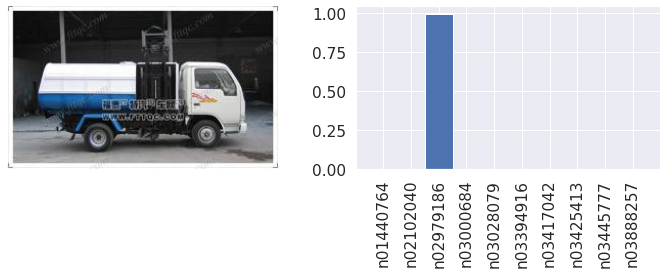

-- Image: data/imagenette2-160/val/n03417042/n03417042_3140.JPEG


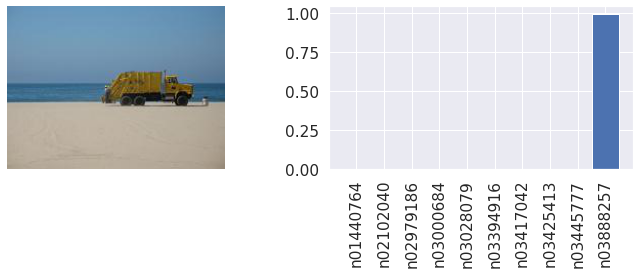



== Class : n03425413
-- Image: data/imagenette2-160/val/n03425413/n03425413_14040.JPEG


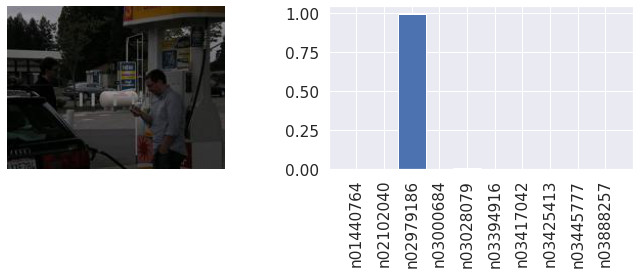

-- Image: data/imagenette2-160/val/n03425413/n03425413_11061.JPEG


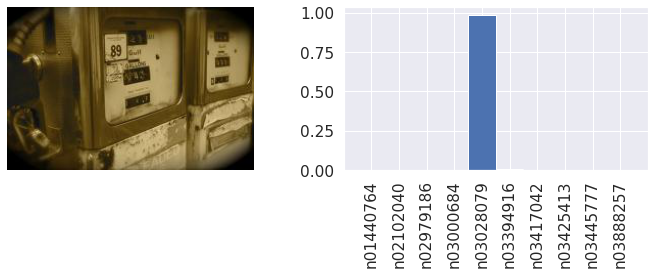



== Class : n03445777
-- Image: data/imagenette2-160/val/n03445777/n03445777_5932.JPEG


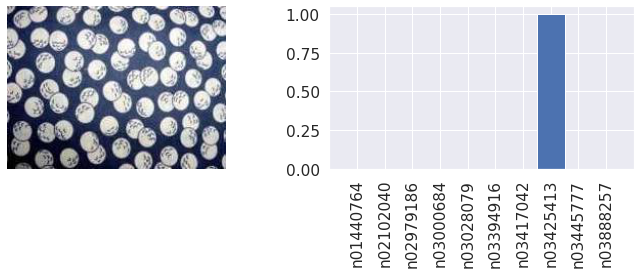

-- Image: data/imagenette2-160/val/n03445777/n03445777_5492.JPEG


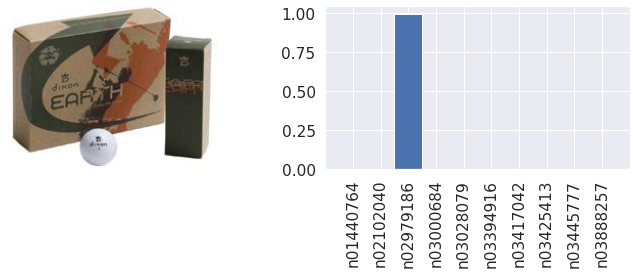



== Class : n03888257
-- Image: data/imagenette2-160/val/n03888257/n03888257_21932.JPEG


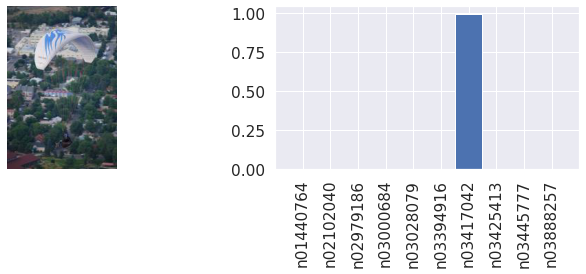

-- Image: data/imagenette2-160/val/n03888257/n03888257_4732.JPEG


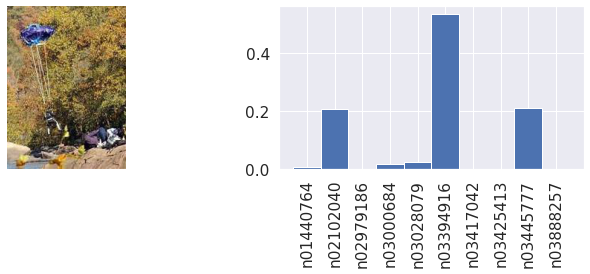

In [256]:
for cn in valid_dl.class_indices:
    print(f"\n\n== Class : {cn}")
    cv = valid_dl.class_indices[cn]
    mask = valid_dl.classes[argsrt_losses] == cv
    for i, ii in enumerate(argsrt_losses[mask][:-3:-1]):
        print(f"-- Image: {valid_dl.filepaths[ii]}")
        _, axs = plt.subplots(1, 2, figsize=(12, 3))
        axs[0].imshow(PIL.Image.open(valid_dl.filepaths[ii]))
        axs[0].axis("off")
        # axs[0].set_title(valid_dl.filepaths[ii])
        #
        # axs[1].axis("off")
        c = ['b']*valid_dl.num_classes
        c[valid_dl.classes[ii]] = 'r'
        axs[1].bar(list(valid_dl.class_indices.keys()), Y_pred_sft[ii], 1, color=c)
        plt.xticks(rotation=90)
        plt.show()
        print("".join(["="]*25))
#

# 7. Hyperparameter Tuning

## 7-1. Batch Size

Here we are doubling the batch size from the default size of **32 to 64**. This would result in halving the steps per epoch as compared to batch size of 32.

In [22]:
train_dl.batch_size = 64

In [ ]:
reg = tf.keras.regularizers.l2()
reg = None
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, 2, padding='same', input_shape=x_batch.shape[1:], data_format="channels_last", kernel_regularizer=reg),
  layers.BatchNormalization(),
  layers.Activation("relu"),
  #
  layers.Conv2D(32, 3, 2, padding='same', kernel_regularizer=reg),
  layers.BatchNormalization(),
  layers.Activation("relu"),
  #
  layers.Conv2D(64, 3, 2, padding='same', kernel_regularizer=reg),
  layers.BatchNormalization(),
  layers.Activation("relu"),
  #
  layers.Conv2D(128, 3, 2, padding='same', kernel_regularizer=reg),
  layers.BatchNormalization(),
  layers.Activation("relu"),
  #
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128),
  layers.BatchNormalization(),
  layers.Activation("relu"),
  #
  layers.Dropout(0.4),
  layers.Dense(len(train_dl.class_indices), kernel_regularizer=reg)
])
#
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.003),
    loss=tf.keras.losses.BinaryCrossentropy(True),
    metrics=['accuracy']
)

In [262]:
import time
start = time.time()

history = model.fit_generator(
    train_dl,
    epochs=50,
    validation_data=valid_dl
)

f"-- Total Time Taken to train model: {(time.time() - start)/60:0.3f} Minutes"

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
148/148 [==============================] - 57s 376ms/step - loss: 0.4217 - accuracy: 0.2225 - val_loss: 0.2936 - val_accuracy: 0.2991
Epoch 2/50
148/148 [==============================] - 55s 375ms/step - loss: 0.2849 - accuracy: 0.3369 - val_loss: 0.2606 - val_accuracy: 0.3926
Epoch 3/50
148/148 [==============================] - 55s 375ms/step - loss: 0.2680 - accuracy: 0.3857 - val_loss: 0.3716 - val_accuracy: 0.2617
Epoch 4/50
148/148 [==============================] - 56s 375ms/step - loss: 0.2570 - accuracy: 0.4149 - val_loss: 0.2436 - val_accuracy: 0.4446
Epoch 5/50
148/148 [==============================] - 56s 377ms/step - loss: 0.2519 - accuracy: 0.4304 - val_loss: 0.2857 - val_accuracy: 0.3878
Epoch 6/50
148/148 [==============================] - 55s 375ms/step - loss: 0.2422 - accuracy: 0.4616 - val_loss: 0.2531 - val_accuracy: 0.4354
Epoch 7/50
148/148 [==============================] - 56s 375ms/step - loss: 0.2392 - accuracy: 0.4762 - val_loss: 0.2236 - val_ac

'-- Total Time Taken to train model: 46.301 Minutes'

In [3]:
h = f"""
-- Final Model Metrics: 
> Training Loss: {history.history['loss'][-1]:0.3f}     | Validation Loss: {history.history['val_loss'][-1]:0.3f} 
> Training Accuracy: {history.history['accuracy'][-1]:0.3f} | Validation Accuracy: {history.history['val_accuracy'][-1]:0.3f} 
"""
print(h)


-- Final Model Metrics: 
> Training Loss: 0.163     | Validation Loss: 0.183 
> Training Accuracy: 0.660 | Validation Accuracy: 0.626 



We have changed the batch size to double which will initially halve the number of steps and double the loss magnitude. The loss magnitude has doubles because of sum reduction of loss calculated over each image in the batch.

## 7-2. Dropout

In [264]:
## Reset Batch size
train_dl.batch_size = 32

In [263]:
reg = tf.keras.regularizers.l2()
reg = None
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, 2, padding='same', input_shape=x_batch.shape[1:], data_format="channels_last", kernel_regularizer=reg),
  layers.BatchNormalization(),
  layers.Activation("relu"),
  #
  layers.Conv2D(32, 3, 2, padding='same', kernel_regularizer=reg),
  layers.BatchNormalization(),
  layers.Activation("relu"),
  #
  layers.Conv2D(64, 3, 2, padding='same', kernel_regularizer=reg),
  layers.BatchNormalization(),
  layers.Activation("relu"),
  #
  layers.Dropout(0.4),
  layers.Conv2D(128, 3, 2, padding='same', kernel_regularizer=reg),
  layers.BatchNormalization(),
  layers.Activation("relu"),
  #
  layers.Flatten(),
  layers.Dense(128),
  layers.BatchNormalization(),
  layers.Activation("relu"),
  #
  layers.Dropout(0.5),
  layers.Dense(len(train_dl.class_indices), kernel_regularizer=reg)
])
#
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.003),
    loss=tf.keras.losses.BinaryCrossentropy(True),
    metrics=['accuracy']
)

In [265]:
import time
start = time.time()

history = model.fit_generator(
    train_dl,
    epochs=50,
    validation_data=valid_dl
)

f"-- Total Time Taken to train model: {(time.time() - start)/60:0.3f} Minutes"

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
296/296 [==============================] - 58s 191ms/step - loss: 0.4048 - accuracy: 0.1952 - val_loss: 0.2911 - val_accuracy: 0.2994
Epoch 2/50
296/296 [==============================] - 57s 191ms/step - loss: 0.2879 - accuracy: 0.3188 - val_loss: 0.2653 - val_accuracy: 0.3738
Epoch 3/50
296/296 [==============================] - 56s 190ms/step - loss: 0.2698 - accuracy: 0.3800 - val_loss: 0.3705 - val_accuracy: 0.2645
Epoch 4/50
296/296 [==============================] - 57s 191ms/step - loss: 0.2619 - accuracy: 0.3998 - val_loss: 0.2483 - val_accuracy: 0.4201
Epoch 5/50
296/296 [==============================] - 57s 191ms/step - loss: 0.2567 - accuracy: 0.4299 - val_loss: 0.2531 - val_accuracy: 0.4257
Epoch 6/50
296/296 [==============================] - 56s 191ms/step - loss: 0.2539 - accuracy: 0.4283 - val_loss: 0.2329 - val_accuracy: 0.4634
Epoch 7/50
296/296 [==============================] - 56s 190ms/step - loss: 0.2483 - accuracy: 0.4443 - val_loss: 0.2208 - val_ac

'-- Total Time Taken to train model: 47.161 Minutes'

In [4]:
h = f"""
-- Final Model Metrics: 
> Training Loss: {history.history['loss'][-1]:0.3f}     | Validation Loss: {history.history['val_loss'][-1]:0.3f} 
> Training Accuracy: {history.history['accuracy'][-1]:0.3f} | Validation Accuracy: {history.history['val_accuracy'][-1]:0.3f} 
"""
print(h)


-- Final Model Metrics: 
> Training Loss: 0.181     | Validation Loss: 0.179 
> Training Accuracy: 0.635 | Validation Accuracy: 0.629 



Here we increased the dropout a little bit before top layer and moved a dropout layer from between two dense layers to two convolution layers. 
> - Because of the increasing the dropout before the top layer we see better validation loss and accuracy as compared to the previous model.
> - Because of moving a dropout layer from between two dense layers to between two convolutions layers we see a slight dip in the training accuracy.